In [8]:
from bookworm import *

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,9)

import pandas as pd
import numpy as np
import networkx as nx
import random

# Stable Marriages
There's a lovely piece of classic game theory known as the the 'Stable Marriage Problem' which is famously solved by the Gale-Shapley Algorithm.  
The story given to provide intuition often changes from telling to telling, but here I'll use a story of a town's villagers. For the sake of mathematical simplicity we're going to have to make some reductive assumptions about the townspeople's genders and sexulaities - there are two genders in this town, the population is evenly split between the two genders, and everyone is heterosexual. The townspeople need to be married off to one another for the sake of good and wholesome society, and each person has an ordered list of spousal preferences. Men propose to women, and women can accept or reject any of those proposals at any time until overall stability is achieved. For example:

| Proposor |   |   |   |   |
|----------|---|---|---|---|
| Man 1    | 2 | 1 | 3 | 4 |
| Man 2    | 4 | 1 | 2 | 3 |
| Man 3    | 1 | 3 | 2 | 4 |
| Man 4    | 2 | 3 | 1 | 4 |

| Acceptor |   |   |   |   |
|----------|---|---|---|---|
| Woman 1  | 1 | 3 | 2 | 4 |
| Woman 2  | 3 | 4 | 1 | 2 |
| Woman 3  | 4 | 2 | 3 | 1 |
| Woman 4  | 3 | 2 | 1 | 4 |

_Man 1_ would ideally like to marry _Woman 2_, followed by _Woman 1_, _Woman 3_ and finally _Woman 4_, etc.  
The problem, now, is to find a set of pairings between townspeople which leaves the population maximally satisfied. Note that we're maximising satisfaction for the _whole population_ here, not individuals - Some people will inevitably miss out on a marriage with their ideal partner because they've already chosen to marry somebody else, or because their preferences are misaligned. The solution we want to approach here is one of _equilibrium_ or _stability_ - ie no person will deviate from their marriage becuase, due to the stability of the other couples around them, their interests are maximised by remaining in the marriage. There are no two people of opposite gender who would both rather have each other than their current partners.

### The Gale-Shapley Algorithm
The solution proposed by Gale and Shapley in 1962 says that we'll need to take an iterative approach to arriving at that maximally satisfied set of pairings. First, each man proposes to his ideal partner - some women might get several proposals at this stage, and some might receive none (see the double instance of _Woman 2_ in column 1 of the Proposors' table above). The women then pick their first choice from their set of proposals, and a provisional engagement is established between those pairs. The non-engaged men then propose to their next preference (regardless of whether or not she is already engaged). If the woman prefers the idea of marriage with this man to her current state, she accepts. In some cases this leads to an engaged man to be jilted in favour of another man. This step is repeated until all men and women have a partner.  
Gale-Shapley is proven to maximise satisfaction within the group, and thereby leave everyone with a marriage from which they will not deviate.

### Implementing Gale-Shapley in Python
We can write a quick, ugly implementation of the algorithm described above 

In [2]:
def gale_shapley(proposors, acceptors):
    '''
    Returns stable marriage pairings for a given set of input 
    candidates and their lists of spousal preferences

    Parameters
    ----------
    proposors : dict (required)
        the set of men and their list of spousal preferences
    acceptors : dict (required)
        the set of women and their list of spousal preferences

    Returns
    -------
    marriages : dict
        the list of stable marriage pairings
    '''
    is_man_available = {man: True for man in proposors}
    is_woman_available = {woman: True for woman in acceptors}
    
    proposals_tried = {man: [] for man in proposors}
    engagements = {person: None for person in list(proposors) + list(acceptors)}
    
    while any(is_man_available[man] is True for man in proposors):
        available_men = [man for man in list(proposors) if is_man_available[man]]
        
        for man in available_men:
            untried_proposals = [w for w in proposors[man] if w not in proposals_tried[man]]

            preferred_woman = untried_proposals[0]
            
            if is_woman_available[preferred_woman]:
                engagements[man] = preferred_woman
                
                is_man_available[man] = False
                is_woman_available[preferred_woman] = False
                
                engagements[man] = preferred_woman
                engagements[preferred_woman] = man
            
            elif engagements[preferred_woman] is not None:
                current_fiance = engagements[preferred_woman]
                
                current_fiance_index = acceptors[preferred_woman].index(current_fiance)
                new_proposor_index = acceptors[preferred_woman].index(man)
                
                if new_proposor_index < current_fiance_index:
                    engagements[current_fiance] = None
                    is_man_available[current_fiance] = True

                    engagements[preferred_woman] = man

                    is_man_available[man] = False
                    engagements[man] = preferred_woman
                    
                else:
                    is_man_available[man] = True
            
            proposals_tried[man].append(preferred_woman)

    return engagements

Lets see what happens when we apply the algorithm to our example village above

In [64]:
proposors = {'man_1': ['woman_2', 'woman_1', 'woman_3', 'woman_4'],
             'man_2': ['woman_4', 'woman_1', 'woman_2', 'woman_3'],
             'man_3': ['woman_1', 'woman_3', 'woman_2', 'woman_4'],
             'man_4': ['woman_2', 'woman_3', 'woman_1', 'woman_4']}

acceptors = {'woman_1': ['man_1', 'man_3', 'man_2', 'man_4'],
             'woman_2': ['man_3', 'man_4', 'man_1', 'man_2'],
             'woman_3': ['man_4', 'man_2', 'man_3', 'man_1'],
             'woman_4': ['man_3', 'man_2', 'man_1', 'man_4']}

In [65]:
gale_shapley(proposors, acceptors)

{'man_1': 'woman_5',
 'man_2': 'woman_4',
 'man_3': 'woman_1',
 'man_4': 'woman_2',
 'woman_1': 'man_3',
 'woman_2': 'man_4',
 'woman_3': None,
 'woman_4': 'man_2',
 'woman_5': 'man_1'}

Despite looking quite long and convoluted function, this thing is wicked fast. It's basically just a couple of `if`s stretched out into a very tall function

In [5]:
%%timeit
gale_shapley(proposors, acceptors)

17 µs ± 304 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


we can add a new woman to the mix and see what happens

In [67]:
proposors = {'man_1': ['woman_5', 'woman_2', 'woman_1', 'woman_3', 'woman_4'],
             'man_2': ['woman_4', 'woman_1', 'woman_5', 'woman_2', 'woman_3'],
             'man_3': ['woman_1', 'woman_5', 'woman_3', 'woman_2', 'woman_4'],
             'man_4': ['woman_2', 'woman_3', 'woman_1', 'woman_4', 'woman_5']}

acceptors = {'woman_1': ['man_1', 'man_3', 'man_2', 'man_4'],
             'woman_2': ['man_3', 'man_4', 'man_1', 'man_2'],
             'woman_3': ['man_4', 'man_2', 'man_3', 'man_1'],
             'woman_4': ['man_3', 'man_2', 'man_1', 'man_4'],
             'woman_5': ['man_3', 'man_2', 'man_1', 'man_4']}

gale_shapley(proposors, acceptors)

{'man_1': 'woman_5',
 'man_2': 'woman_4',
 'man_3': 'woman_1',
 'man_4': 'woman_2',
 'woman_1': 'man_3',
 'woman_2': 'man_4',
 'woman_3': None,
 'woman_4': 'man_2',
 'woman_5': 'man_1'}

and switch the genders of the proposors / acceptors

In [66]:
acceptors = {'man_1': ['woman_5', 'woman_2', 'woman_1', 'woman_3', 'woman_4'],
             'man_2': ['woman_4', 'woman_1', 'woman_5', 'woman_2', 'woman_3'],
             'man_3': ['woman_1', 'woman_5', 'woman_3', 'woman_2', 'woman_4'],
             'man_4': ['woman_2', 'woman_3', 'woman_1', 'woman_4', 'woman_5']}

proposors = {'woman_1': ['man_1', 'man_3', 'man_2', 'man_4'],
             'woman_2': ['man_3', 'man_4', 'man_1', 'man_2'],
             'woman_3': ['man_4', 'man_2', 'man_3', 'man_1'],
             'woman_4': ['man_3', 'man_2', 'man_1', 'man_4'],
             'woman_5': ['man_3', 'man_2', 'man_1', 'man_4']}

gale_shapley(proposors, acceptors)

IndexError: list index out of range

We get an error, as there aren't enough acceptors to propose to and the algorithm relies on all the proposors being matched at the end of the process. It doesn't really matter if an acceptor is left behind, but the proposors must all be married.

# Stable Marriages in Novels
I thought it might be fun to invoke Gale-Shapley on our bookworm networks. We have a list of characters with some kind of preference metric enumerated already - the only thing we're missing is the gender of each character. A problem in modern English literature is that character networks are often vastly asymmetric regarding gender.  
We can ascribe gender randomly and use the algorithm outlined above:

visualised, the random splitting looks something like this

In [145]:
book = bookworm('data/raw/hp_philosophers_stone.txt', threshold=-1)

/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnin

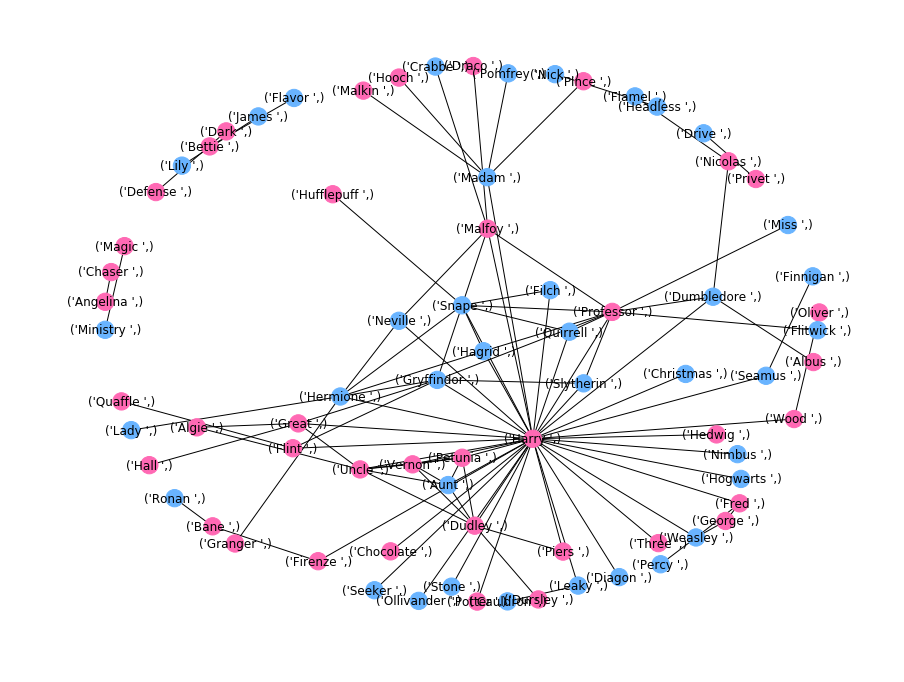

In [146]:
G = nx.from_pandas_dataframe(book[book['value'] > 2], 
                             source='source', 
                             target='target')

genders = {character: random.choice(['#69B4FF', '#FF69B4']) 
           for character in G.nodes()}

nx.draw(G,
        cmap=plt.get_cmap("RdYlBu"),
        node_color=list(genders.values()),
        with_labels=True)

However, we need to include all nodes and ignore colour, so we'll use the following code

In [95]:
G = nx.from_pandas_dataframe(book,
                             source='source',
                             target='target')

genders = {character: random.choice(['M', 'F']) for character in G.nodes()}

we want to build dataframes of the men's and women's preferences

In [97]:
is_male = lambda x: True if genders[x] == 'M' else False

men = book[(book['source'].apply(is_male)) & (~book['target'].apply(is_male))]
women = book[(~book['source'].apply(is_male)) & (book['target'].apply(is_male))]

male_preferences = {character: list(men
                                    [men['source'] == character]
                                    .set_index('target')
                                    ['value']
                                    .sort_values(ascending=False)
                                    .index.values)
                    for character in genders if genders[character] == 'M'}

female_preferences = {character: list(women
                                      [women['source'] == character]
                                      .set_index('target')
                                      ['value']
                                      .sort_values(ascending=False)
                                      .index.values)
                      for character in genders if genders[character] == 'F'}

In [101]:
pd.Series(genders).value_counts()

M    350
F    318
dtype: int64

we have more men than women this time around, so we'll have to have the women proposing to men

In [102]:
marriages = gale_shapley(female_preferences, male_preferences)

Lets see who Harry's has been paired up with...

In [104]:
marriages["('Harry ',)"]

"('Hermione ',)"

In [110]:
marriages["('Hagrid \',)"]

"('Snape ',)"

Again, we can wrap this up more neatly to simplify the process of using gale-shapley with any graph

In [119]:
def get_gendered_preferences(interaction_df):
    '''
    set up for the stable marriages algorithm. splits a character graph 
    randomly into genders and determines an ordered list of preferences for 
    them.
    
    Parameters
    ----------
    inderaction_df : pd.DataFrame (required)
        the dataframe of interactions upon which we want to base our stable 
        marriages
        source = character one
        target = character two
        value = strength of interaction between character one and character two
    
    Returns
    -------
    proposors : dict
        keys = all proposing characters
        values = sorted list of preferences for the character in question
    acceptors : dict
        keys = all accepting characters
        values = sorted list of preferences for the character in question
    '''
    G = nx.from_pandas_dataframe(interaction_df,
                                 source='source',
                                 target='target')

    genders = {character: random.choice(['M', 'F']) for character in G.nodes()}
    n_men = pd.Series(genders).value_counts()['M']
    n_women = pd.Series(genders).value_counts()['F']
    
    is_male = lambda x: True if genders[x] == 'M' else False

    men = interaction_df[(interaction_df['source'].apply(is_male)) & 
                         (~interaction_df['target'].apply(is_male))]
    
    women = interaction_df[(~interaction_df['source'].apply(is_male)) & 
                           (interaction_df['target'].apply(is_male))]
    
    male_preferences = {character: list(men[men['source'] == character]
                                        .set_index('target')
                                        ['value']
                                        .sort_values(ascending=False)
                                        .index.values)
                        for character in genders if genders[character] == 'M'}
    
    female_preferences = {character: list(women[women['source'] == character]
                                          .set_index('target')
                                          ['value']
                                          .sort_values(ascending=False)
                                          .index.values)
                          for character in genders if genders[character] == 'F'}
    
    if n_men > n_women:
        proposors, acceptors = female_preferences, male_preferences
    else:
        proposors, acceptors = male_preferences, female_preferences
    return proposors, acceptors

In [120]:
proposors, acceptors = get_gendered_preferences(book)

marriages = gale_shapley(proposors, acceptors)

marriages["('Harry ',)"]

"('Hermione ',)"

The Stable Marriages problem requires a bipartite graph, which is something we don't have naturally here - our network is genderless at the beginning and it has to be awkwardly imposed.  
We can adapt our problem to ignore gender. The genderless version of the problem is the lesser known _Stable Roommates_ problem, solved by Irving in 1985.

## Stable Roommates

In [ ]:
def irving(population):
    roommates = {p: None for p in population}
    return roommates